# 10. 이미지 (Object segmenation)
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
```

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob

## 개념정리

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)



* Classification (분류): 인풋에 대해서 하나의 레이블을 예측하는 작업.
AlexNet, ResNet, Xception 등의 모델
* Localization/Detection (발견): 물체의 레이블을 예측하면서 그 물체가 어디에 있는지 정보를 제공. 물체가 있는 곳에 네모를 그리는 등
YOLO, R-CNN 등의 모델
* Segmentation (분할): 모든 픽셀의 레이블을 예측
FCN, SegNet, DeepLab 등의 모델


---
### **모델 구조**
---


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

**Input**
* RGB color 이미지 (height X width X 3) 또는 흑백 (height X width X 1) 이미지

**Output**
* 각 필셀별 어느 class 에 속하는지 나타내는 레이블을 나타낸 Segmentation Map

![](https://miro.medium.com/max/700/1*p-F6uIUf6jmcM8VcVQarGQ.png)





![](https://miro.medium.com/max/700/1*lZEdphf72ZMwOhsDq-eEfg.png)


## 실습

---
### **데이터셋: Crowd Instance-level Human Parsing (CIHP)**
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

#### **1. 데이터셋 다운로드**

* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

```
! gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
! unzip -q instance-level-human-parsing.zip
```

In [3]:
! gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
! unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:37<00:00, 77.7MB/s]


#### **2. 데이터셋 경로 확보**

In [9]:
DATA_DIR = '/content/instance-level_human_parsing/instance-level_human_parsing/'

In [10]:
train_img_paths = sorted(glob.glob('%s/Training/Images/*jpg'%DATA_DIR))
train_mask_paths = sorted(glob.glob('%s/Training/Category_ids/*'%DATA_DIR))

valid_img_paths = sorted(glob.glob('%s/Validation/Images/*jpg'%DATA_DIR))
valid_mask_paths = sorted(glob.glob('%s/Validation/Category_ids/*'%DATA_DIR))
print('* Training',len(train_img_paths),len(train_mask_paths))
print('* Validation',len(valid_img_paths),len(valid_mask_paths))

* Training 28280 28280
* Validation 5000 5000


#### **3. 데이터 시각화**

In [11]:
from tensorflow.keras import utils
from PIL import ImageOps

In [12]:
def plot_img_mask(img,mask,cmap='gray'):
  plt.figure(figsize=(20,10))
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img)
  plt.imshow(mask,alpha=0.6,cmap =cmap)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask,cmap = cmap)
  plt.show()



(330, 500)
(330, 500)


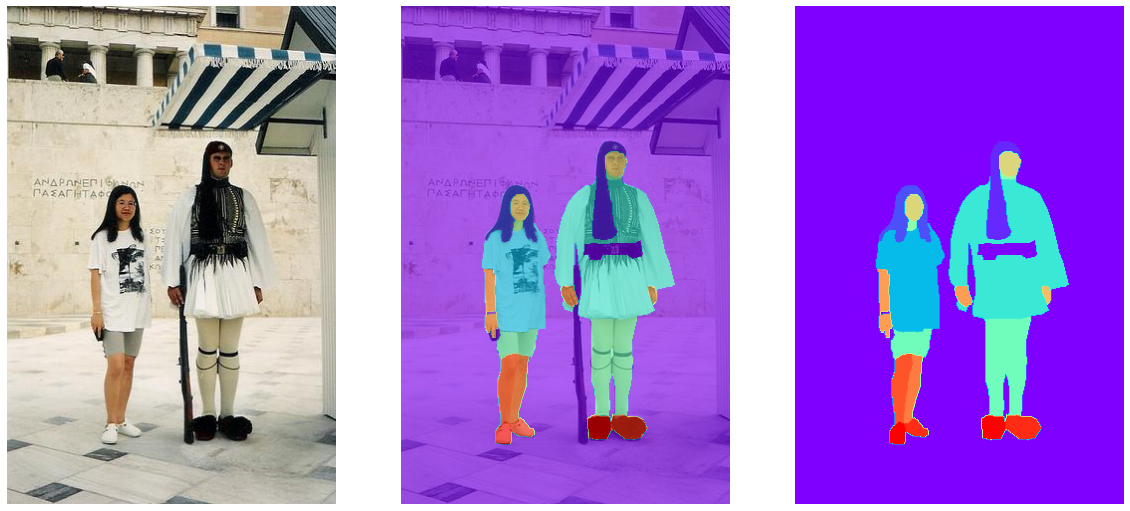

In [13]:
idx= 8
img = utils.load_img(train_img_paths[idx])
print(img.size)

mask = utils.load_img(train_mask_paths[idx],color_mode='grayscale')
mask = ImageOps.autocontrast(mask)
print(mask.size) 
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img)
plt.imshow(mask,alpha=0.6,cmap ='rainbow')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mask,cmap = 'rainbow')
plt.show()


#### **4. 데이터 프로세스**

In [14]:
IMG_SIZE = 160
BATCH_SIZE =8
NUM_CLASSES = 20

In [15]:
img_path = train_img_paths[0]
mask_path = train_mask_paths[0]
def read_from_path(img_path,mask_path):


#이미지
  img = tf.io.read_file(img_path)
  img =tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,size=[IMG_SIZE,IMG_SIZE])
  img=img/127.5-1

#마스크
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask,channels=1)
  mask = tf.image.resize(mask,size=[IMG_SIZE,IMG_SIZE])
  mask = tf.cast(mask,tf.int8)   #타입 정하지않으면 자동으로 플롯 타입이되어버린다
  return img,mask


In [16]:
def generate_ds(img_paths,mask_paths):
  ds = tf.data.Dataset.from_tensor_slices((img_paths,mask_paths))
  ds = ds.map(read_from_path, num_parallel_calls=tf.data.AUTOTUNE)#데이터셋 셋팅 빨라지게 하는거
  ds = ds.batch(BATCH_SIZE,drop_remainder=True)
  return ds  

In [17]:
train_ds = generate_ds(train_img_paths,train_mask_paths)
valid_ds = generate_ds(valid_img_paths,valid_mask_paths)
train_ds,valid_ds

(<BatchDataset shapes: ((8, 160, 160, 3), (8, 160, 160, 1)), types: (tf.float32, tf.int8)>,
 <BatchDataset shapes: ((8, 160, 160, 3), (8, 160, 160, 1)), types: (tf.float32, tf.int8)>)

---
### **모델**
---


In [ ]:
from tensorflow.keras import layers, models, Input, utils

def build_model(img_size, num_classes):
  inputs = Input(shape=( img_size, img_size, 3) )

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x
#크기를 줄이는부분
  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x
#크기를 다시 키우는 부분
  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

#### **1.모델 생성**

In [ ]:
model= build_model(IMG_SIZE,NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

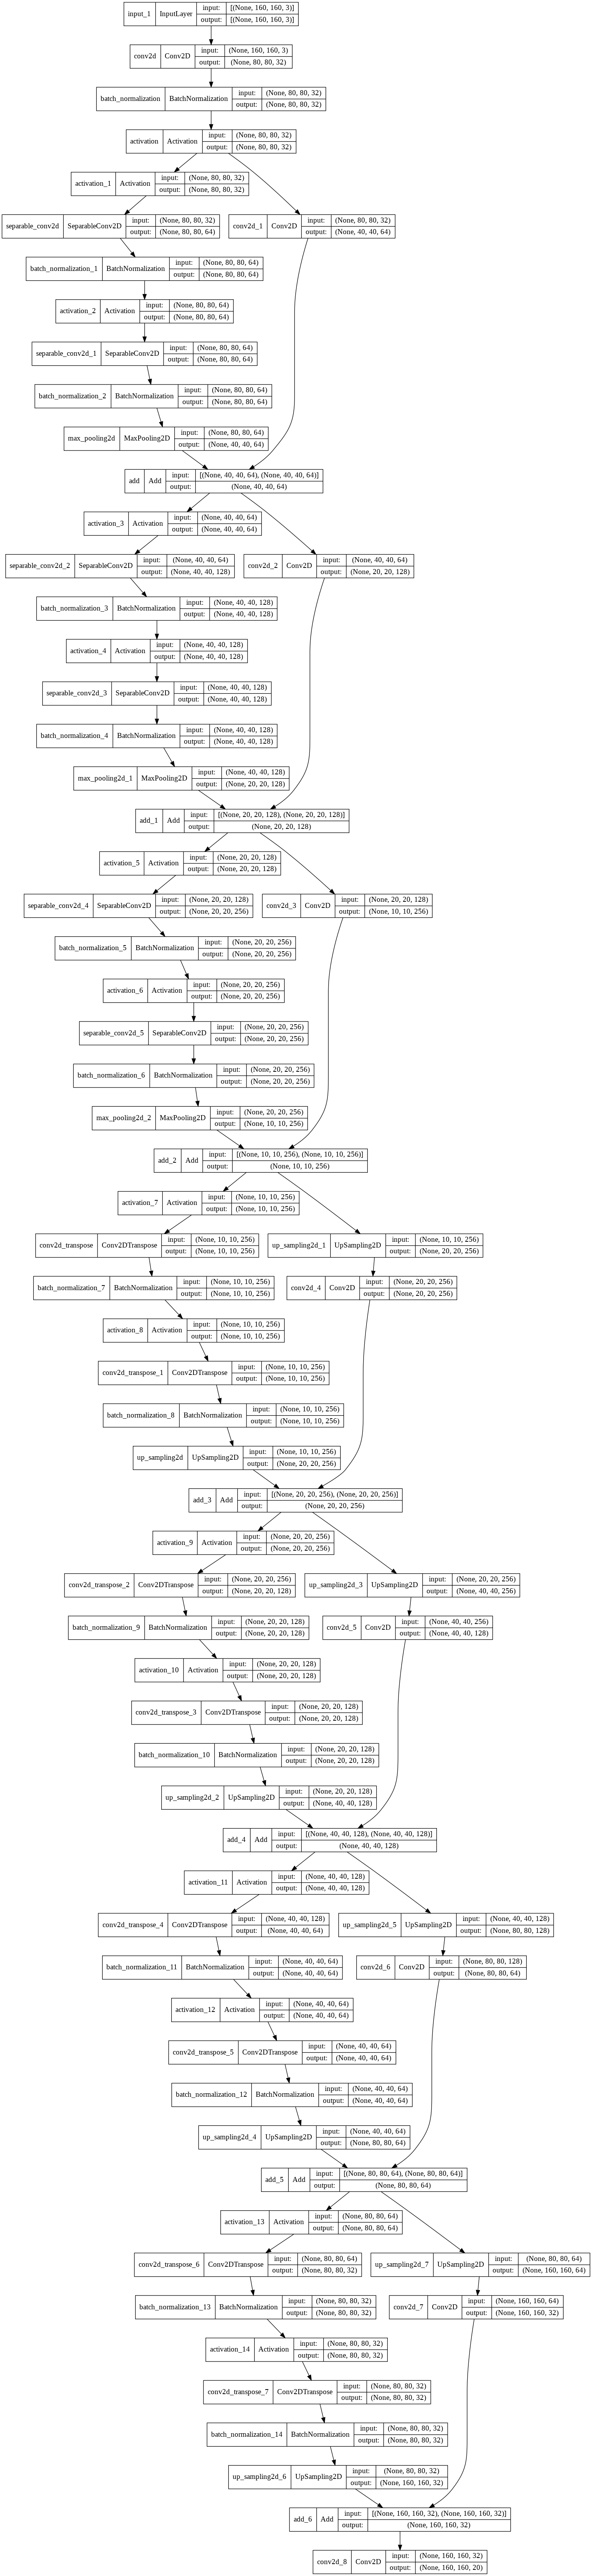

In [ ]:
utils.plot_model(model,show_shapes=True)  #model.summary()보다 더 상세히 표현해준다

#중간중간 뛰어넘어가고 합쳐지는걸 residual이라고한다

#### **2. 모델 컴파일**

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()  #위에서 원핫 인코딩 안썻기때문에 sparse써야한다
optimizer = tf.keras.optimizers.Adam()

In [ ]:
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

#### **3. 모델 학습**

In [ ]:
from tensorflow.keras import callbacks
ckp =callbacks.ModelCheckpoint('model.h5',save_best_only=True)
history=model.fit(train_ds,
                  validation_data=valid_ds,
                  epochs=10,
                  callbacks=[ckp])

Epoch 1/10
3535/3535 [==============================] - ETA: 0s - loss: 1.0511 - accuracy: 0.6803

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3535/3535 [==============================] - 514s 142ms/step - loss: 1.0511 - accuracy: 0.6803 - val_loss: 0.8894 - val_accuracy: 0.7245
Epoch 2/10
3535/3535 [==============================] - 520s 147ms/step - loss: 0.8475 - accuracy: 0.7356 - val_loss: 0.8032 - val_accuracy: 0.7527
Epoch 3/10
3535/3535 [==============================] - 522s 148ms/step - loss: 0.7741 - accuracy: 0.7587 - val_loss: 0.7744 - val_accuracy: 0.7627
Epoch 4/10
3535/3535 [==============================] - 524s 148ms/step - loss: 0.7260 - accuracy: 0.7739 - val_loss: 0.7607 - val_accuracy: 0.7676
Epoch 5/10
3535/3535 [==============================] - 508s 144ms/step - loss: 0.6885 - accuracy: 0.7861 - val_loss: 0.7426 - val_accuracy: 0.7748
Epoch 6/10
3535/3535 [==============================] - 499s 141ms/step - loss: 0.6579 - accuracy: 0.7965 - val_loss: 0.7565 - val_accuracy: 0.7731
Epoch 7/10
3535/3535 [==============================] - 502s 142ms/step - loss: 0.6316 - accuracy: 0.8055 - val_loss: 0.766

KeyboardInterrupt: ignored

#### **4. 모델 평가**

In [ ]:
model.evaluate(valid_ds)

625/625 [==============================] - 30s 48ms/step - loss: 0.7709 - accuracy: 0.7727


[0.7709360122680664, 0.7726605534553528]

---
### **추론**
---

In [ ]:
idx = 5
#img_path = valid_img_paths[idx]
img_path='street1.jpg'
mask_path = valid_mask_paths[idx]
img, mask = read_from_path(img_path,mask_path)
pred = model.predict(tf.expand_dims(img,0))
pred =np.argmax(pred[0],axis=2)
pred.shape

(160, 160)

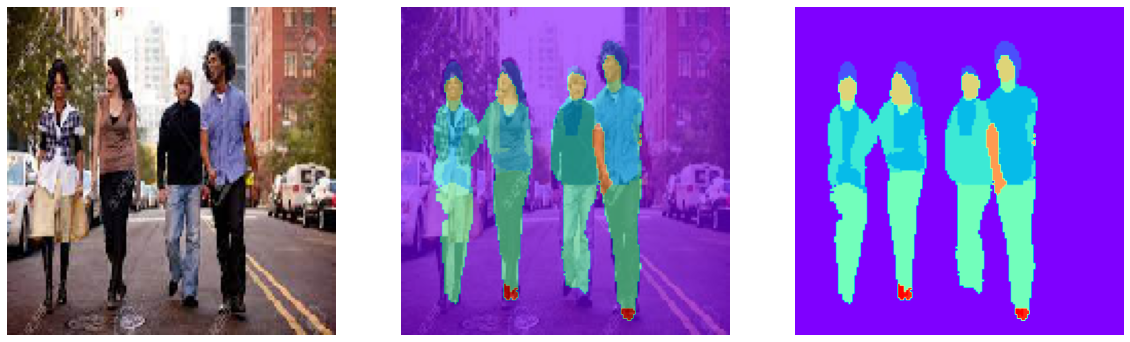

In [ ]:
img = utils.load_img(img_path,target_size=(IMG_SIZE,IMG_SIZE))
plot_img_mask(img,pred,cmap='rainbow')
plt.show()